### GRL - miniproject

In [1]:
# Code reused from GRL practicals
!python -c "import torch; print(torch.__version__)"



2.1.0+cu121


In [2]:
!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y

%env TORCH=2.1.1+cu118
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-geometric

Found existing installation: torch-scatter 2.1.2
Uninstalling torch-scatter-2.1.2:
  Successfully uninstalled torch-scatter-2.1.2
Found existing installation: torch-sparse 0.6.18
Uninstalling torch-sparse-0.6.18:
  Successfully uninstalled torch-sparse-0.6.18
Found existing installation: torch-geometric 2.4.0
Uninstalling torch-geometric-2.4.0:
  Successfully uninstalled torch-geometric-2.4.0
env: TORCH=2.1.1+cu118
Looking in links: https://data.pyg.org/whl/torch-2.1.1+cu118.html
  Using cached torch_scatter-2.1.2-cp38-cp38-linux_x86_64.whl
Looking in links: https://data.pyg.org/whl/torch-2.1.1+cu118.html
  Using cached torch_sparse-0.6.18-cp38-cp38-linux_x86_64.whl
  Using cached torch_geometric-2.4.0-py3-none-any.whl (1.0 MB)


In [42]:
import matplotlib.pyplot as plt
import networkx as nx
import igraph as ig
import scipy.sparse as sp
import numpy as np
import torch
import os
import typing
import pickle
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

#### GCN Model

In [4]:
# Adapted from the code submitted on Practical 4

class GCN(nn.Module):
    def __init__(self,
                 input_dim,
                 hidden_dim,
                 num_classes,
                 num_layers,
                 dropout_ratio: float = 0.3):
        
        super(GCN, self).__init__()
        self.num_layers = num_layers
        self.dropout = nn.Dropout(dropout_ratio)
        self.conv_layers = nn.ModuleList()

        # Adding input layer
        self.conv_layers.append(GCNConv(input_dim, hidden_dim))
        
        # Adding hidden layers
        for _ in range(num_layers - 1):
            self.conv_layers.append(GCNConv(hidden_dim, hidden_dim))

        # Add output layer
        self.last_conv_layer = GCNConv(hidden_dim, num_classes)

    def forward(self, X, edge_index):
        for i in range(self.num_layers):
            X = self.conv_layers[i](X, edge_index)
            X = F.relu(X)
            X = self.dropout(X)
        
        X = self.last_conv_layer(X,edge_index) 
        return  F.log_softmax(X, dim=1)


    def reset_parameters(self):
        for conv in self.conv_layers:
            conv.reset_parameters()
        self.last_conv_layer.reset_parameters()

#### GAT Model

The following code is a simplification of the code in: https://github.com/gordicaleksa/pytorch-GAT/tree/main 

In [1]:
# AUTHOR'S CODE ORIGINAL COMMENTS
import enum


# Supported datasets - only Cora in this notebook
class DatasetType(enum.Enum):
    CORA = 0

    
# Networkx is not precisely made with drawing as its main feature but I experimented with it a bit
class GraphVisualizationTool(enum.Enum):
    NETWORKX = 0,
    IGRAPH = 1


# We'll be dumping and reading the data from this directory
DATA_DIR_PATH = os.path.join(os.getcwd(), 'data')
CORA_PATH = os.path.join(DATA_DIR_PATH, 'cora')  # this is checked-in no need to make a directory

#
# Cora specific constants
#

# Thomas Kipf et al. first used this split in GCN paper and later Petar Veličković et al. in GAT paper
CORA_TRAIN_RANGE = [0, 140]  # we're using the first 140 nodes as the training nodes
CORA_VAL_RANGE = [140, 140+500]
CORA_TEST_RANGE = [1708, 1708+1000]
CORA_NUM_INPUT_FEATURES = 1433
CORA_NUM_CLASSES = 7

# Used whenever we need to visualzie points from different classes (t-SNE, CORA visualization)
cora_label_to_color_map = {0: "red", 1: "blue", 2: "green", 3: "orange", 4: "yellow", 5: "pink", 6: "gray"}

In [15]:
# All Cora data is stored as pickle
def pickle_read(path):
    with open(path, 'rb') as file:
        data = pickle.load(file)

    return data

def pickle_save(path, data):
    with open(path, 'wb') as file:
        pickle.dump(data, file, protocol=pickle.HIGHEST_PROTOCOL)

In [55]:
def load_graph_data(training_config, device):
    dataset_name = DatasetType.CORA.name

    # shape = (N, FIN), where N is the number of nodes and FIN is the number of input features
    node_features_csr = pickle_read(os.path.join(CORA_PATH, 'node_features.csr'))
    # shape = (N, 1)
    node_labels_npy = pickle_read(os.path.join(CORA_PATH, 'node_labels.npy'))
    # shape = (N, number of neighboring nodes) <- this is a dictionary not a matrix!
    adjacency_list_dict = pickle_read(os.path.join(CORA_PATH, 'adjacency_list.dict'))

    # Normalize the features (helps with training)
    node_features_csr = normalize_features_sparse(node_features_csr)
    num_of_nodes = len(node_labels_npy)

    # shape = (2, E), where E is the number of edges, and 2 for source and target nodes. Basically edge index
    # contains tuples of the format S->T, e.g. 0->3 means that node with id 0 points to a node with id 3.
    topology = build_edge_index(adjacency_list_dict, num_of_nodes, add_self_edges=True)

    # Note: topology is just a fancy way of naming the graph structure data 
    # (aside from edge index it could be in the form of an adjacency matrix)

    # Convert to dense PyTorch tensors

    # Needs to be long int type because later functions like PyTorch's index_select expect it
    topology = torch.tensor(topology, dtype=torch.long, device=device)
    node_labels = torch.tensor(node_labels_npy, dtype=torch.long, device=device)  # Cross entropy expects a long int
    node_features = torch.tensor(node_features_csr.todense(), device=device)

    # Indices that help us extract nodes that belong to the train/val and test splits
    train_indices = torch.arange(CORA_TRAIN_RANGE[0], CORA_TRAIN_RANGE[1], dtype=torch.long, device=device)
    val_indices = torch.arange(CORA_VAL_RANGE[0], CORA_VAL_RANGE[1], dtype=torch.long, device=device)
    test_indices = torch.arange(CORA_TEST_RANGE[0], CORA_TEST_RANGE[1], dtype=torch.long, device=device)

    return node_features, node_labels, topology, train_indices, val_indices, test_indices

In [6]:
def normalize_features_sparse(node_features_sparse):
    assert sp.issparse(node_features_sparse), f'Expected a sparse matrix, got {node_features_sparse}.'

    # Instead of dividing (like in normalize_features_dense()) we do multiplication with inverse sum of features.
    # Modern hardware (GPUs, TPUs, ASICs) is optimized for fast matrix multiplications! ^^ (* >> /)
    # shape = (N, FIN) -> (N, 1), where N number of nodes and FIN number of input features
    node_features_sum = np.array(node_features_sparse.sum(-1))  # sum features for every node feature vector

    # Make an inverse (remember * by 1/x is better (faster) then / by x)
    # shape = (N, 1) -> (N)
    node_features_inv_sum = np.power(node_features_sum, -1).squeeze()

    # Again certain sums will be 0 so 1/0 will give us inf so we replace those by 1 which is a neutral element for mul
    node_features_inv_sum[np.isinf(node_features_inv_sum)] = 1.

    # Create a diagonal matrix whose values on the diagonal come from node_features_inv_sum
    diagonal_inv_features_sum_matrix = sp.diags(node_features_inv_sum)

    # We return the normalized features.
    return diagonal_inv_features_sum_matrix.dot(node_features_sparse)

In [7]:
def build_edge_index(adjacency_list_dict, num_of_nodes, add_self_edges=True):
    source_nodes_ids, target_nodes_ids = [], []
    seen_edges = set()

    for src_node, neighboring_nodes in adjacency_list_dict.items():
        for trg_node in neighboring_nodes:
            # if this edge hasn't been seen so far we add it to the edge index (coalescing - removing duplicates)
            if (src_node, trg_node) not in seen_edges:  # it'd be easy to explicitly remove self-edges (Cora has none..)
                source_nodes_ids.append(src_node)
                target_nodes_ids.append(trg_node)

                seen_edges.add((src_node, trg_node))

    if add_self_edges:
        source_nodes_ids.extend(np.arange(num_of_nodes))
        target_nodes_ids.extend(np.arange(num_of_nodes))

    # shape = (2, E), where E is the number of edges in the graph
    edge_index = np.row_stack((source_nodes_ids, target_nodes_ids))

    return edge_index

In [20]:
import torch
import pickle
def plot_in_out_degree_distributions():
    pass

def visualize_graph():
    pass

config = {
    'should_visualize': False,
    'dataset_name' : DatasetType.CORA.name
}

node_features, node_labels, edge_index, train_indices, val_indices, test_indices = load_graph_data(config, device)

print(node_features.shape, node_features.dtype)
print(node_labels.shape, node_labels.dtype)
print(edge_index.shape, edge_index.dtype)
print(train_indices.shape, train_indices.dtype)
print(val_indices.shape, val_indices.dtype)
print(test_indices.shape, test_indices.dtype)

torch.Size([2708, 1433]) torch.float32
torch.Size([2708]) torch.int64
torch.Size([2, 13264]) torch.int64
torch.Size([140]) torch.int64
torch.Size([500]) torch.int64
torch.Size([1000]) torch.int64


In [21]:
import torch.nn as nn
from torch.optim import Adam


class GAT(torch.nn.Module):
    """
    """

    def __init__(self, num_of_layers, num_heads_per_layer, num_features_per_layer, add_skip_connection=True, bias=True,
                 dropout=0.6, log_attention_weights=False):
        super().__init__()
        assert num_of_layers == len(num_heads_per_layer) == len(num_features_per_layer) - 1, f'Enter valid arch params.'

        num_heads_per_layer = [1] + num_heads_per_layer 

        gat_layers = []  # collect GAT layers
        for i in range(num_of_layers):
            layer = GATLayer(
                num_in_features=num_features_per_layer[i] * num_heads_per_layer[i],  # consequence of concatenation
                num_out_features=num_features_per_layer[i+1],
                num_of_heads=num_heads_per_layer[i+1],
                concat=True if i < num_of_layers - 1 else False,  # last GAT layer does mean avg, the others do concat
                activation=nn.ELU() if i < num_of_layers - 1 else None,  # last layer just outputs raw scores
                dropout_prob=dropout,
                add_skip_connection=add_skip_connection,
                bias=bias,
                log_attention_weights=log_attention_weights
            )
            gat_layers.append(layer)

        self.gat_net = nn.Sequential(
            *gat_layers,
        )

    # data is just a (in_nodes_features, edge_index) tuple, I had to do it like this because of the nn.Sequential:
    # https://discuss.pytorch.org/t/forward-takes-2-positional-arguments-but-3-were-given-for-nn-sqeuential-with-linear-layers/65698
    def forward(self, data):
        return self.gat_net(data)

In [22]:
class GATLayer(torch.nn.Module):
    """
    Implementation #3 was inspired by PyTorch Geometric: https://github.com/rusty1s/pytorch_geometric

    But, it's hopefully much more readable! (and of similar performance)

    """
    
    # We'll use these constants in many functions so just extracting them here as member fields
    src_nodes_dim = 0  # position of source nodes in edge index
    trg_nodes_dim = 1  # position of target nodes in edge index

    # These may change in the inductive setting - leaving it like this for now (not future proof)
    nodes_dim = 0      # node dimension (axis is maybe a more familiar term nodes_dim is the position of "N" in tensor)
    head_dim = 1       # attention head dim

    def __init__(self, num_in_features, num_out_features, num_of_heads, concat=True, activation=nn.ELU(),
                 dropout_prob=0.6, add_skip_connection=True, bias=True, log_attention_weights=False):

        super().__init__()

        self.num_of_heads = num_of_heads
        self.num_out_features = num_out_features
        self.concat = concat  # whether we should concatenate or average the attention heads
        self.add_skip_connection = add_skip_connection

        #
        # Trainable weights: linear projection matrix (denoted as "W" in the paper), attention target/source
        # (denoted as "a" in the paper) and bias (not mentioned in the paper but present in the official GAT repo)
        #

        # You can treat this one matrix as num_of_heads independent W matrices
        self.linear_proj = nn.Linear(num_in_features, num_of_heads * num_out_features, bias=False)

        # After we concatenate target node (node i) and source node (node j) we apply the "additive" scoring function
        # which gives us un-normalized score "e". Here we split the "a" vector - but the semantics remain the same.
        # Basically instead of doing [x, y] (concatenation, x/y are node feature vectors) and dot product with "a"
        # we instead do a dot product between x and "a_left" and y and "a_right" and we sum them up
        self.scoring_fn_target = nn.Parameter(torch.Tensor(1, num_of_heads, num_out_features))
        self.scoring_fn_source = nn.Parameter(torch.Tensor(1, num_of_heads, num_out_features))

        # Bias is definitely not crucial to GAT - feel free to experiment (I pinged the main author, Petar, on this one)
        if bias and concat:
            self.bias = nn.Parameter(torch.Tensor(num_of_heads * num_out_features))
        elif bias and not concat:
            self.bias = nn.Parameter(torch.Tensor(num_out_features))
        else:
            self.register_parameter('bias', None)

        if add_skip_connection:
            self.skip_proj = nn.Linear(num_in_features, num_of_heads * num_out_features, bias=False)
        else:
            self.register_parameter('skip_proj', None)

        #
        # End of trainable weights
        #

        self.leakyReLU = nn.LeakyReLU(0.2)  # using 0.2 as in the paper, no need to expose every setting
        self.activation = activation
        # Probably not the nicest design but I use the same module in 3 locations, before/after features projection
        # and for attention coefficients. Functionality-wise it's the same as using independent modules.
        self.dropout = nn.Dropout(p=dropout_prob)

        self.log_attention_weights = log_attention_weights  # whether we should log the attention weights
        self.attention_weights = None  # for later visualization purposes, I cache the weights here

        self.init_params()
        
    def forward(self, data):
        #
        # Step 1: Linear Projection + regularization
        #

        in_nodes_features, edge_index = data  # unpack data
        num_of_nodes = in_nodes_features.shape[self.nodes_dim]
        assert edge_index.shape[0] == 2, f'Expected edge index with shape=(2,E) got {edge_index.shape}'

        # shape = (N, FIN) where N - number of nodes in the graph, FIN - number of input features per node
        # We apply the dropout to all of the input node features (as mentioned in the paper)
        # Note: for Cora features are already super sparse so it's questionable how much this actually helps
        in_nodes_features = self.dropout(in_nodes_features)

        # shape = (N, FIN) * (FIN, NH*FOUT) -> (N, NH, FOUT) where NH - number of heads, FOUT - num of output features
        # We project the input node features into NH independent output features (one for each attention head)
        nodes_features_proj = self.linear_proj(in_nodes_features).view(-1, self.num_of_heads, self.num_out_features)

        nodes_features_proj = self.dropout(nodes_features_proj)  # in the official GAT imp they did dropout here as well

        #
        # Step 2: Edge attention calculation
        #

        # Apply the scoring function (* represents element-wise (a.k.a. Hadamard) product)
        # shape = (N, NH, FOUT) * (1, NH, FOUT) -> (N, NH, 1) -> (N, NH) because sum squeezes the last dimension
        # Optimization note: torch.sum() is as performant as .sum() in my experiments
        scores_source = (nodes_features_proj * self.scoring_fn_source).sum(dim=-1)
        scores_target = (nodes_features_proj * self.scoring_fn_target).sum(dim=-1)

        # We simply copy (lift) the scores for source/target nodes based on the edge index. Instead of preparing all
        # the possible combinations of scores we just prepare those that will actually be used and those are defined
        # by the edge index.
        # scores shape = (E, NH), nodes_features_proj_lifted shape = (E, NH, FOUT), E - number of edges in the graph
        scores_source_lifted, scores_target_lifted, nodes_features_proj_lifted = self.lift(scores_source, scores_target, nodes_features_proj, edge_index)
        scores_per_edge = self.leakyReLU(scores_source_lifted + scores_target_lifted)

        # shape = (E, NH, 1)
        attentions_per_edge = self.neighborhood_aware_softmax(scores_per_edge, edge_index[self.trg_nodes_dim], num_of_nodes)
        # Add stochasticity to neighborhood aggregation
        attentions_per_edge = self.dropout(attentions_per_edge)

        #
        # Step 3: Neighborhood aggregation
        #

        # Element-wise (aka Hadamard) product. Operator * does the same thing as torch.mul
        # shape = (E, NH, FOUT) * (E, NH, 1) -> (E, NH, FOUT), 1 gets broadcast into FOUT
        nodes_features_proj_lifted_weighted = nodes_features_proj_lifted * attentions_per_edge

        # This part sums up weighted and projected neighborhood feature vectors for every target node
        # shape = (N, NH, FOUT)
        out_nodes_features = self.aggregate_neighbors(nodes_features_proj_lifted_weighted, edge_index, in_nodes_features, num_of_nodes)

        #
        # Step 4: Residual/skip connections, concat and bias
        #

        out_nodes_features = self.skip_concat_bias(attentions_per_edge, in_nodes_features, out_nodes_features)
        return (out_nodes_features, edge_index)

    #
    # Helper functions (without comments there is very little code so don't be scared!)
    #

    def neighborhood_aware_softmax(self, scores_per_edge, trg_index, num_of_nodes):
        """
        As the fn name suggest it does softmax over the neighborhoods. Example: say we have 5 nodes in a graph.
        Two of them 1, 2 are connected to node 3. If we want to calculate the representation for node 3 we should take
        into account feature vectors of 1, 2 and 3 itself. Since we have scores for edges 1-3, 2-3 and 3-3
        in scores_per_edge variable, this function will calculate attention scores like this: 1-3/(1-3+2-3+3-3)
        (where 1-3 is overloaded notation it represents the edge 1-3 and its (exp) score) and similarly for 2-3 and 3-3
         i.e. for this neighborhood we don't care about other edge scores that include nodes 4 and 5.

        Note:
        Subtracting the max value from logits doesn't change the end result but it improves the numerical stability
        and it's a fairly common "trick" used in pretty much every deep learning framework.
        Check out this link for more details:

        https://stats.stackexchange.com/questions/338285/how-does-the-subtraction-of-the-logit-maximum-improve-learning

        """
        # Calculate the numerator. Make logits <= 0 so that e^logit <= 1 (this will improve the numerical stability)
        scores_per_edge = scores_per_edge - scores_per_edge.max()
        exp_scores_per_edge = scores_per_edge.exp()  # softmax

        # Calculate the denominator. shape = (E, NH)
        neigborhood_aware_denominator = self.sum_edge_scores_neighborhood_aware(exp_scores_per_edge, trg_index, num_of_nodes)

        # 1e-16 is theoretically not needed but is only there for numerical stability (avoid div by 0) - due to the
        # possibility of the computer rounding a very small number all the way to 0.
        attentions_per_edge = exp_scores_per_edge / (neigborhood_aware_denominator + 1e-16)

        # shape = (E, NH) -> (E, NH, 1) so that we can do element-wise multiplication with projected node features
        return attentions_per_edge.unsqueeze(-1)

    def sum_edge_scores_neighborhood_aware(self, exp_scores_per_edge, trg_index, num_of_nodes):
        # The shape must be the same as in exp_scores_per_edge (required by scatter_add_) i.e. from E -> (E, NH)
        trg_index_broadcasted = self.explicit_broadcast(trg_index, exp_scores_per_edge)

        # shape = (N, NH), where N is the number of nodes and NH the number of attention heads
        size = list(exp_scores_per_edge.shape)  # convert to list otherwise assignment is not possible
        size[self.nodes_dim] = num_of_nodes
        neighborhood_sums = torch.zeros(size, dtype=exp_scores_per_edge.dtype, device=exp_scores_per_edge.device)

        # position i will contain a sum of exp scores of all the nodes that point to the node i (as dictated by the
        # target index)
        neighborhood_sums.scatter_add_(self.nodes_dim, trg_index_broadcasted, exp_scores_per_edge)

        # Expand again so that we can use it as a softmax denominator. e.g. node i's sum will be copied to
        # all the locations where the source nodes pointed to i (as dictated by the target index)
        # shape = (N, NH) -> (E, NH)
        return neighborhood_sums.index_select(self.nodes_dim, trg_index)

    def aggregate_neighbors(self, nodes_features_proj_lifted_weighted, edge_index, in_nodes_features, num_of_nodes):
        size = list(nodes_features_proj_lifted_weighted.shape)  # convert to list otherwise assignment is not possible
        size[self.nodes_dim] = num_of_nodes  # shape = (N, NH, FOUT)
        out_nodes_features = torch.zeros(size, dtype=in_nodes_features.dtype, device=in_nodes_features.device)

        # shape = (E) -> (E, NH, FOUT)
        trg_index_broadcasted = self.explicit_broadcast(edge_index[self.trg_nodes_dim], nodes_features_proj_lifted_weighted)
        # aggregation step - we accumulate projected, weighted node features for all the attention heads
        # shape = (E, NH, FOUT) -> (N, NH, FOUT)
        out_nodes_features.scatter_add_(self.nodes_dim, trg_index_broadcasted, nodes_features_proj_lifted_weighted)

        return out_nodes_features

    def lift(self, scores_source, scores_target, nodes_features_matrix_proj, edge_index):
        """
        Lifts i.e. duplicates certain vectors depending on the edge index.
        One of the tensor dims goes from N -> E (that's where the "lift" comes from).

        """
        src_nodes_index = edge_index[self.src_nodes_dim]
        trg_nodes_index = edge_index[self.trg_nodes_dim]

        # Using index_select is faster than "normal" indexing (scores_source[src_nodes_index]) in PyTorch!
        scores_source = scores_source.index_select(self.nodes_dim, src_nodes_index)
        scores_target = scores_target.index_select(self.nodes_dim, trg_nodes_index)
        nodes_features_matrix_proj_lifted = nodes_features_matrix_proj.index_select(self.nodes_dim, src_nodes_index)

        return scores_source, scores_target, nodes_features_matrix_proj_lifted

    def explicit_broadcast(self, this, other):
        # Append singleton dimensions until this.dim() == other.dim()
        for _ in range(this.dim(), other.dim()):
            this = this.unsqueeze(-1)

        # Explicitly expand so that shapes are the same
        return this.expand_as(other)

    def init_params(self):
        """
        The reason we're using Glorot (aka Xavier uniform) initialization is because it's a default TF initialization:
            https://stackoverflow.com/questions/37350131/what-is-the-default-variable-initializer-in-tensorflow

        The original repo was developed in TensorFlow (TF) and they used the default initialization.
        Feel free to experiment - there may be better initializations depending on your problem.

        """
        nn.init.xavier_uniform_(self.linear_proj.weight)
        nn.init.xavier_uniform_(self.scoring_fn_target)
        nn.init.xavier_uniform_(self.scoring_fn_source)

        if self.bias is not None:
            torch.nn.init.zeros_(self.bias)

    def skip_concat_bias(self, attention_coefficients, in_nodes_features, out_nodes_features):
        if self.log_attention_weights:  # potentially log for later visualization in playground.py
            self.attention_weights = attention_coefficients

        if self.add_skip_connection:  # add skip or residual connection
            if out_nodes_features.shape[-1] == in_nodes_features.shape[-1]:  # if FIN == FOUT
                # unsqueeze does this: (N, FIN) -> (N, 1, FIN), out features are (N, NH, FOUT) so 1 gets broadcast to NH
                # thus we're basically copying input vectors NH times and adding to processed vectors
                out_nodes_features += in_nodes_features.unsqueeze(1)
            else:
                # FIN != FOUT so we need to project input feature vectors into dimension that can be added to output
                # feature vectors. skip_proj adds lots of additional capacity which may cause overfitting.
                out_nodes_features += self.skip_proj(in_nodes_features).view(-1, self.num_of_heads, self.num_out_features)

        if self.concat:
            # shape = (N, NH, FOUT) -> (N, NH*FOUT)
            out_nodes_features = out_nodes_features.view(-1, self.num_of_heads * self.num_out_features)
        else:
            # shape = (N, NH, FOUT) -> (N, FOUT)
            out_nodes_features = out_nodes_features.mean(dim=self.head_dim)

        if self.bias is not None:
            out_nodes_features += self.bias

        return out_nodes_features if self.activation is None else self.activation(out_nodes_features)

In [23]:


# 3 different model training/eval phases used in train.py
class LoopPhase(enum.Enum):
    TRAIN = 0,
    VAL = 1,
    TEST = 2

    
# writer = SummaryWriter()  # (tensorboard) writer will output to ./runs/ directory by default


# Global vars used for early stopping. After some number of epochs (as defined by the patience_period var) without any
# improvement on the validation dataset (measured via accuracy metric), we'll break out from the training loop.
BEST_VAL_ACC = 0
BEST_VAL_LOSS = 0
PATIENCE_CNT = 0

BINARIES_PATH = os.path.join(os.getcwd(), 'models', 'binaries')
CHECKPOINTS_PATH = os.path.join(os.getcwd(), 'models', 'checkpoints')

# Make sure these exist as the rest of the code assumes it
os.makedirs(BINARIES_PATH, exist_ok=True)
os.makedirs(CHECKPOINTS_PATH, exist_ok=True)

In [24]:
import git
import re  # regex


def get_training_state(training_config, model):
    training_state = {
        "commit_hash": git.Repo(search_parent_directories=True).head.object.hexsha,

        # Training details
        "dataset_name": training_config['dataset_name'],
        "num_of_epochs": training_config['num_of_epochs'],
        "test_acc": training_config['test_acc'],

        # Model structure
        "num_of_layers": training_config['num_of_layers'],
        "num_heads_per_layer": training_config['num_heads_per_layer'],
        "num_features_per_layer": training_config['num_features_per_layer'],
        "add_skip_connection": training_config['add_skip_connection'],
        "bias": training_config['bias'],
        "dropout": training_config['dropout'],

        # Model state
        "state_dict": model.state_dict()
    }

    return training_state


def print_model_metadata(training_state):
    header = f'\n{"*"*5} Model training metadata: {"*"*5}'
    print(header)

    for key, value in training_state.items():
        if key != 'state_dict':  # don't print state_dict just a bunch of numbers...
            print(f'{key}: {value}')
    print(f'{"*" * len(header)}\n')


# This one makes sure we don't overwrite the valuable model binaries (feel free to ignore - not crucial to GAT method)
def get_available_binary_name():
    prefix = 'gat'

    def valid_binary_name(binary_name):
        # First time you see raw f-string? Don't worry the only trick is to double the brackets.
        pattern = re.compile(rf'{prefix}_[0-9]{{6}}\.pth')
        return re.fullmatch(pattern, binary_name) is not None

    # Just list the existing binaries so that we don't overwrite them but write to a new one
    valid_binary_names = list(filter(valid_binary_name, os.listdir(BINARIES_PATH)))
    if len(valid_binary_names) > 0:
        last_binary_name = sorted(valid_binary_names)[-1]
        new_suffix = int(last_binary_name.split('.')[0][-6:]) + 1  # increment by 1
        return f'{prefix}_{str(new_suffix).zfill(6)}.pth'
    else:
        return f'{prefix}_000000.pth'

In [76]:
import argparse


def get_training_args(params):
    
    parser = argparse.ArgumentParser()

    # Training related

    parser.add_argument("--patience_period", type=int, help="number of epochs with no improvement on val before terminating", default=1000)

    parser.add_argument("--should_test", type=bool, help='should test the model on the test dataset?', default=True)

    # Dataset related
    parser.add_argument("--dataset_name", choices=[el.name for el in DatasetType], help='dataset to use for training', default=DatasetType.CORA.name)
    parser.add_argument("--should_visualize", type=bool, help='should visualize the dataset?', default=False)

    # Logging/debugging/checkpoint related (helps a lot with experimentation)
    parser.add_argument("--enable_tensorboard", type=bool, help="enable tensorboard logging", default=False)
    parser.add_argument("--console_log_freq", type=int, help="log to output console (epoch) freq (None for no logging)", default=100)
    parser.add_argument("--checkpoint_freq", type=int, help="checkpoint model saving (epoch) freq (None for no logging)", default=1000)
    args = parser.parse_args("")

    # Model architecture related - this is the architecture as defined in the official paper (for Cora classification)
    gat_config = {
        "lr": params["lr"],
        "weight_decay": params["weight_decay"],
        "num_of_epochs": params["epochs"],
        "num_of_layers": params["n_layers"],  # GNNs, contrary to CNNs, are often shallow (it ultimately depends on the graph properties)
        "num_heads_per_layer": [8, 1],
        "num_features_per_layer": [CORA_NUM_INPUT_FEATURES, 8, CORA_NUM_CLASSES],
        "add_skip_connection": False,  # hurts perf on Cora
        "bias": False,  # result is not so sensitive to bias
        "dropout": params["dropout"]   # result is sensitive to dropout
    }

    # Wrapping training configuration into a dictionary
    training_config = dict()
    for arg in vars(args):
        training_config[arg] = getattr(args, arg)

    # Add additional config information
    training_config.update(gat_config)

    return training_config

In [104]:
import time


def train_gat(config):
    global BEST_VAL_ACC, BEST_VAL_LOSS

    # Step 1: load the graph data
    node_features, node_labels, edge_index, train_indices, val_indices, test_indices = load_graph_data(config, device)

    # Step 2: prepare the model
    gat = GAT(
        num_of_layers=config['num_of_layers'],
        num_heads_per_layer=config['num_heads_per_layer'],
        num_features_per_layer=config['num_features_per_layer'],
        add_skip_connection=config['add_skip_connection'],
        bias=config['bias'],
        dropout=config['dropout'],
        log_attention_weights=False  # no need to store attentions, used only in playground.py while visualizing
    ).to(device)

    # Step 3: Prepare other training related utilities (loss & optimizer and decorator function)
    loss_fn = nn.CrossEntropyLoss(reduction='mean')
    optimizer = Adam(gat.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])

    # THIS IS THE CORE OF THE TRAINING (we'll define it in a minute)
    # The decorator function makes things cleaner since there is a lot of redundancy between the train and val loops
    main_loop = get_main_loop(
        config,
        gat,
        loss_fn,
        optimizer,
        node_features,
        node_labels,
        edge_index,
        train_indices,
        val_indices,
        test_indices,
        config['patience_period'],
        time.time())

    BEST_VAL_ACC, BEST_VAL_LOSS, PATIENCE_CNT = [0, 0, 0]  # reset vars used for early stopping
    


    # Step 4: Start the training procedure
    begin_time = time.time() 
    for epoch in range(config['num_of_epochs']):
        # Training loop
        main_loop(phase=LoopPhase.TRAIN, epoch=epoch)

        # Validation loop
        with torch.no_grad():
            try:
                main_loop(phase=LoopPhase.VAL, epoch=epoch)
            except Exception as e:  # "patience has run out" exception :O
                print(str(e))
                break  # break out from the training loop

    # Step 5: Potentially test your model
    # Don't overfit to the test dataset - only when you've fine-tuned your model on the validation dataset should you
    # report your final loss and accuracy on the test dataset. Friends don't let friends overfit to the test data. <3
    test_acc = 0
    dur  = 0  
    if config['should_test']:
        test_acc = main_loop(phase=LoopPhase.TEST)
        config['test_acc'] = test_acc
        dur =  time.time()-begin_time 
    else:
        config['test_acc'] = -1
    
    return  test_acc,dur   

In [111]:
# Simple decorator function so that I don't have to pass arguments that don't change from epoch to epoch
def get_main_loop(config, gat, cross_entropy_loss, optimizer, node_features, node_labels, edge_index, train_indices, val_indices, test_indices, patience_period, time_start):

    node_dim = 0  # this will likely change as soon as I add an inductive example (Cora is transductive)

    train_labels = node_labels.index_select(node_dim, train_indices)
    val_labels = node_labels.index_select(node_dim, val_indices)
    test_labels = node_labels.index_select(node_dim, test_indices)

    # node_features shape = (N, FIN), edge_index shape = (2, E)
    graph_data = (node_features, edge_index)  # I pack data into tuples because GAT uses nn.Sequential which requires it

    def get_node_indices(phase):
        if phase == LoopPhase.TRAIN:
            return train_indices
        elif phase == LoopPhase.VAL:
            return val_indices
        else:
            return test_indices

    def get_node_labels(phase):
        if phase == LoopPhase.TRAIN:
            return train_labels
        elif phase == LoopPhase.VAL:
            return val_labels
        else:
            return test_labels

    def main_loop(phase, epoch=0):
        global BEST_VAL_ACC, BEST_VAL_LOSS, PATIENCE_CNT, writer

        # Certain modules behave differently depending on whether we're training the model or not.
        # e.g. nn.Dropout - we only want to drop model weights during the training.
        if phase == LoopPhase.TRAIN:
            gat.train()
        else:
            gat.eval()

        node_indices = get_node_indices(phase)
        gt_node_labels = get_node_labels(phase)  # gt stands for ground truth

        # Do a forwards pass and extract only the relevant node scores (train/val or test ones)
        # Note: [0] just extracts the node_features part of the data (index 1 contains the edge_index)
        # shape = (N, C) where N is the number of nodes in the split (train/val/test) and C is the number of classes
        nodes_unnormalized_scores = gat(graph_data)[0].index_select(node_dim, node_indices)

        # Example: let's take an output for a single node on Cora - it's a vector of size 7 and it contains unnormalized
        # scores like: V = [-1.393,  3.0765, -2.4445,  9.6219,  2.1658, -5.5243, -4.6247]
        # What PyTorch's cross entropy loss does is for every such vector it first applies a softmax, and so we'll
        # have the V transformed into: [1.6421e-05, 1.4338e-03, 5.7378e-06, 0.99797, 5.7673e-04, 2.6376e-07, 6.4848e-07]
        # secondly, whatever the correct class is (say it's 3), it will then take the element at position 3,
        # 0.99797 in this case, and the loss will be -log(0.99797). It does this for every node and applies a mean.
        # You can see that as the probability of the correct class for most nodes approaches 1 we get to 0 loss! <3
        loss = cross_entropy_loss(nodes_unnormalized_scores, gt_node_labels)

        if phase == LoopPhase.TRAIN:
            optimizer.zero_grad()  # clean the trainable weights gradients in the computational graph (.grad fields)
            loss.backward()  # compute the gradients for every trainable weight in the computational graph
            optimizer.step()  # apply the gradients to weights

        # Finds the index of maximum (unnormalized) score for every node and that's the class prediction for that node.
        # Compare those to true (ground truth) labels and find the fraction of correct predictions -> accuracy metric.
        class_predictions = torch.argmax(nodes_unnormalized_scores, dim=-1)
        accuracy = torch.sum(torch.eq(class_predictions, gt_node_labels).long()).item() / len(gt_node_labels)

        #
        # Logging
        #

        if phase == LoopPhase.TRAIN:
            # Log metrics
            if config['enable_tensorboard']:
                writer.add_scalar('training_loss', loss.item(), epoch)
                writer.add_scalar('training_acc', accuracy, epoch)

            # # Save model checkpoint
            # if config['checkpoint_freq'] is not None and (epoch + 1) % config['checkpoint_freq'] == 0:
            #     ckpt_model_name = f"gat_ckpt_epoch_{epoch + 1}.pth"
            #     config['test_acc'] = -1
                #torch.save(get_training_state(config, gat), os.path.join(CHECKPOINTS_PATH, ckpt_model_name))

        elif phase == LoopPhase.VAL:
            # Log metrics
            if config['enable_tensorboard']:
                writer.add_scalar('val_loss', loss.item(), epoch)
                writer.add_scalar('val_acc', accuracy, epoch)

            # # Log to console
            # if config['console_log_freq'] is not None and epoch % config['console_log_freq'] == 0:
            #     print(f'GAT training: time elapsed= {(time.time() - time_start):.2f} [s] | epoch={epoch + 1} | val acc={accuracy}')

            # The "patience" logic - should we break out from the training loop? If either validation acc keeps going up
            # or the val loss keeps going down we won't stop
            if accuracy > BEST_VAL_ACC or loss.item() < BEST_VAL_LOSS:
                BEST_VAL_ACC = max(accuracy, BEST_VAL_ACC)  # keep track of the best validation accuracy so far
                BEST_VAL_LOSS = min(loss.item(), BEST_VAL_LOSS)
                PATIENCE_CNT = 0  # reset the counter every time we encounter new best accuracy
            else:
                PATIENCE_CNT += 1  # otherwise keep counting

            if PATIENCE_CNT >= patience_period:
                raise Exception('Stopping the training, the universe has no more patience for this training.')

        else:
            return accuracy  # in the case of test phase we just report back the test accuracy

    return main_loop  # return the decorated function

dataset

In [52]:
def evaluate(
    model,
    data
):
    model.eval()
    with torch.no_grad():
         # Calculate the predicted classes
        outputs = model(data.x, data.edge_index)
        _, predicted = torch.max(outputs.data, 1) # get the maximum probability classes

        # Get the correct classes in the test data original classification
        test_classes = data.y[data.test_mask == True]
        
        # Compare     
        correct = (predicted[data.test_mask == True] == test_classes).sum().item()
                             
    return 100 * correct / len(test_classes)

In [112]:
def train_gcn(
    params: typing.Dict,
    data    
) -> torch.nn.Module:
  """
    This function trains a node classification model and returns the trained model object.
  """

  # Update parameters
  params["n_classes"] = dataset.num_classes # number of target classes
  params["input_dim"] = dataset.num_features # size of input features

  model = GCN(
        params["input_dim"],
        params["hid_dim"],
        params["n_classes"],
        params["n_layers"],
        params["dropout"]
        ).to(device)


  loss_fn = nn.CrossEntropyLoss()
  model_param_group = [{"params": model.parameters(), "lr": params["lr"], "weight_decay":params["weight_decay"]}]
  optimizer = torch.optim.AdamW(model_param_group)

  # Variable to be collected
  accuracies = []
  times = []
  begin_time = time.time() 
  
  for epoch in range(params["epochs"]):
    model.train()

    optimizer.zero_grad()
    output = model(data.x, data.edge_index) 
    y_predicted = output[data.train_mask]
    y_expected = data.y[data.train_mask]
    loss = loss_fn(y_predicted, y_expected)
    loss.backward()
    optimizer.step()

    acc = evaluate(model, data)

    accuracies.append(acc)
    model.reset_parameters()  

  dur =  time.time()-begin_time      
  times.append(dur)
  return accuracies, times
          

In [47]:
dataset = dataset = Planetoid("/tmp/Cora", name="Cora")

data_gcn = dataset.data
data_gcn = data_gcn.to(device)

In [113]:
# Experiments
params = {
    "lr": 5e-3,  # learning rate
    "weight_decay": 5e-4,  # weight_decay
    "hid_dim": 64, # size of hidden features
    "learning_rate": 1e-4,
    "dropout": 0.3,
    'n_layers':2
}

# Variables
times = []   
last_accuracies= [] 
epochs_var = list(range(100,1501, 100))

gcn_accuracies_set = []
gcn_time_set = []

gat_accuracies_set = []
gat_time_set = []


for epochs in epochs_var: 
    print("Number of epochs: ", epochs)
    
    params['epochs'] = epochs
    
    
    # GCN
        
    acc_gnc, times_gcn = train_gcn(params,data_gcn)
    gcn_accuracies_set.append(acc_gnc[-1])
    gcn_time_set.append(times_gcn[-1])
    print("Time GCN", times_gcn[-1])


    # GAT   

    train_params = get_training_args(params)


    accuracies_gat, times_gat = train_gat(train_params)
    gat_accuracies_set.append(accuracies_gat * 100)
    gat_time_set.append(times_gat)  
    print("Time GAT", times_gat)

Number of epochs:  100
Time GCN 3.60449481010437
Test accuracy = 0.816
Time GAT 4.452871799468994
Number of epochs:  200
Time GCN 5.937901258468628
Test accuracy = 0.813
Time GAT 8.864781141281128
Number of epochs:  300
Time GCN 8.70154857635498
Test accuracy = 0.821
Time GAT 13.053779125213623
Number of epochs:  400
Time GCN 11.780457019805908
Test accuracy = 0.824
Time GAT 18.378101110458374
Number of epochs:  500
Time GCN 14.59506368637085
Test accuracy = 0.812
Time GAT 22.6824369430542
Number of epochs:  600
Time GCN 17.644174575805664
Test accuracy = 0.827
Time GAT 27.362501859664917
Number of epochs:  700
Time GCN 20.494580268859863
Test accuracy = 0.818
Time GAT 31.938666582107544
Number of epochs:  800
Time GCN 25.579342126846313
Test accuracy = 0.818
Time GAT 37.02814316749573
Number of epochs:  900
Time GCN 26.055787086486816
Test accuracy = 0.819
Time GAT 41.528499126434326
Number of epochs:  1000
Time GCN 30.183309316635132
Test accuracy = 0.827
Time GAT 45.57989263534546
N

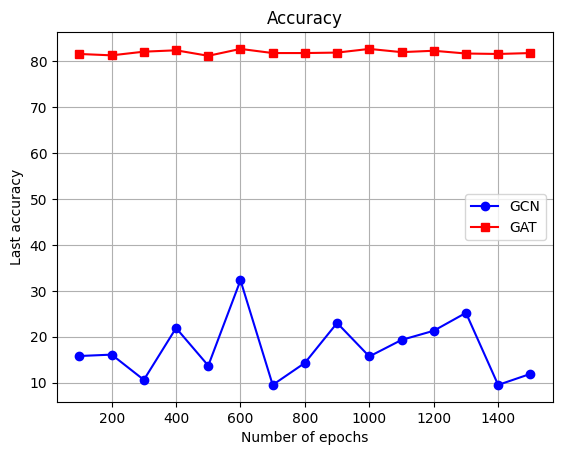

In [114]:
import matplotlib.pyplot as plt


plt.plot(epochs_var, gcn_accuracies_set, label='GCN', linestyle='-', marker='o', color='b')

plt.plot(epochs_var, gat_accuracies_set, label='GAT', linestyle='-', marker='s', color='r')

plt.xlabel('Number of epochs')
plt.ylabel('Last accuracy')
plt.title('Accuracy')

plt.legend()
plt.grid(True)
plt.show()

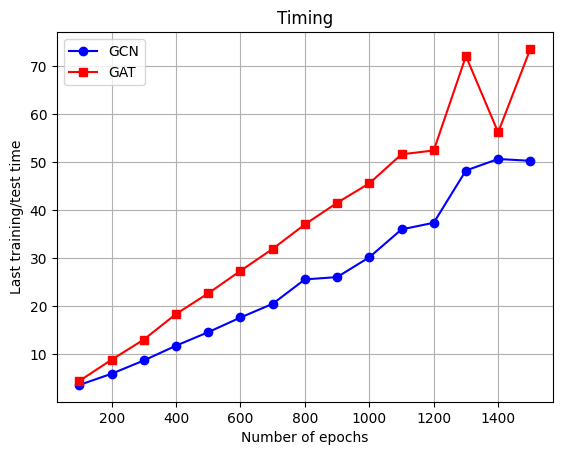

In [116]:


plt.plot(epochs_var, gcn_time_set, label='GCN', linestyle='-', marker='o', color='b')

plt.plot(epochs_var, gat_time_set, label='GAT', linestyle='-', marker='s', color='r')

plt.xlabel('Number of epochs')
plt.ylabel('Last training/test time')
plt.title('Timing')

plt.legend()
plt.grid(True)
plt.show()